In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from jax import vmap
import jax.numpy as jnp
import jax.random as random
import jax

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from scipy.stats import norm

/Users/k_masuda/.pyenv/versions/anaconda3-5.3.1/envs/py38/lib/python3.8/site-packages/tqdm-4.64.0-py3.8.egg/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['figure.figsize'] = (10,5)

In [3]:
data = pd.read_csv("../spectra/eso/uucnc_harps.csv")
data.flux_err = 1. / np.sqrt(data.flux)

/Users/k_masuda/.pyenv/versions/anaconda3-5.3.1/envs/py38/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
wmin, wmax = 5200, 5280
widx = (wmin<data.wave) & (data.wave<wmax)

In [5]:
xdata, ydata = np.array(data.wave[widx]), np.array(data.flux[widx])

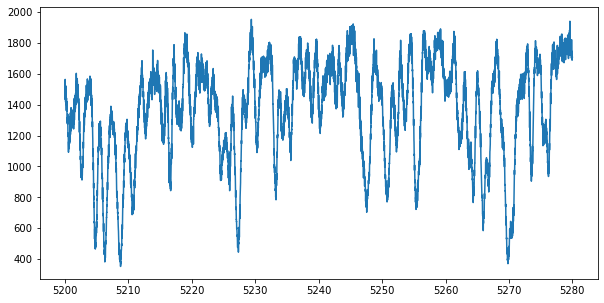

In [6]:
plt.plot(xdata, ydata)

In [12]:
X = jnp.array(xdata)[:,None].T
Y = jnp.array(ydata)[:,None].T

In [15]:
Xmean, Xmax, Xmin = np.mean(X, axis=1)[:,None], np.max(X, axis=1)[:,None], np.min(X, axis=1)[:,None]
Ymean, Ymax, Ymin = np.mean(Y, axis=1)[:,None], np.max(Y, axis=1)[:,None], np.min(Y, axis=1)[:,None]

#%%
Xnorm = (X - Xmean) / (Xmax - Xmin)
Ynorm = (Y - Ymean) / (Ymax - Ymin)

In [17]:
import haiku as hk
def loss_fn(inputs, labels):
    mlp = hk.Sequential([
        hk.Linear(300), jax.nn.leaky_relu,
        hk.Linear(300), jax.nn.leaky_relu,
        hk.Linear(3)
    ])
    out = mlp(inputs)
    return jnp.mean(jnp.abs(labels - out))

In [18]:
loss_fn_t = hk.transform(loss_fn)
loss_fn_t = hk.without_apply_rng(loss_fn_t)

#%%
rng = random.PRNGKey(42)

#%%
params = loss_fn_t.init(rng, Xnorm.T, Ynorm.T)

In [20]:
loss = loss_fn_t.apply(params, Xnorm.T[0], Ynorm.T[0])

#%%
grads = jax.grad(loss_fn_t.apply)(params, Xnorm.T[0], Ynorm.T[0])

In [23]:
def sgd(param, update):
    return param - 1e-4 * update

In [25]:
x, y = Xnorm.T, Ynorm.T
nall = len(Xnorm.T)
nbatch = int(2**6)
nmax = int(nall / nbatch) + 1
losses = [1e10]
print (nmax * nbatch, nall)
for i in range(int(1e2)):
    if i % 10 == 0:
        print (i, losses[-1])
    rngkey = random.PRNGKey(i)
    xperm = random.permutation(rngkey, Xnorm.T)
    yperm = random.permutation(rngkey, Ynorm.T)
    for j in range(nmax+1):
        _x, _y = xperm[nbatch*j:nbatch*(j+1)], yperm[nbatch*j:nbatch*(j+1)]
        grads = jax.grad(loss_fn_t.apply)(params, _x, _y)
        params = jax.tree_multimap(sgd, params, grads)
    losses.append(loss_fn_t.apply(params, x, y))
losses = np.array(losses)

8000 7999
0 10000000000.0
10 0.15790887
20 0.15704206
30 0.1565783
40 0.15627073
50 0.15604262
60 0.15585178
70 0.15568328
80 0.15553235
90 0.15539609


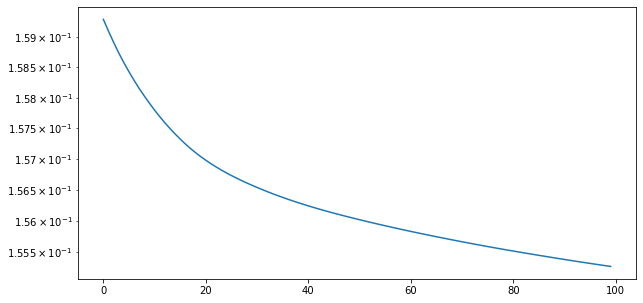

In [26]:
plt.yscale("log")
#plt.ylim(6000, 1e4)
plt.plot(losses[1:])

In [29]:
def predict(x, params):
    z1 = jax.nn.leaky_relu(jnp.matmul(x, params['linear']['w']) + params['linear']['b'])
    z2 = jax.nn.leaky_relu(jnp.matmul(z1, params['linear_1']['w']) + params['linear_1']['b'])
    return jnp.matmul(z2, params['linear_2']['w']) + params['linear_2']['b']
    z3 = jax.nn.relu(jnp.matmul(z2, params['linear_2']['w']) + params['linear_2']['b'])
    return jnp.matmul(z3, params['linear_3']['w']) + params['linear_3']['b']

In [30]:
y_pred_norm = predict(x, params)

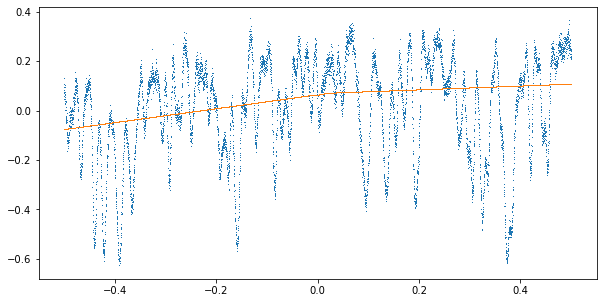

In [32]:
for i in range(1):
    plt.figure()
    plt.plot(x.T[0], y.T[i], ',')
    plt.plot(x.T[0], y_pred_norm.T[i], ',')